<a href="https://colab.research.google.com/github/NganTran-0017/HIDS/blob/main/DL_HIDS_ADFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Processing data**

In [1]:
#@title Specify parameters before running
CLEAN =  True#@param {type:"boolean"} # Indicate to clean data or not. Used in Data Cleaning section
SZ =  1#@param {type:"number"}         # Indicate a fraction number to sample train set when it's too big. Located in Data Partition

SEQ_WINDOW =  25#@param {type:"integer"} # Indicate the window length to parse the sequence into. Used in Data Parsing section
BATCH_SZ =  256#@param {type:"integer"}
EPOCHS =  2#@param {type:"integer"}


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, auc, recall_score, precision_score,plot_confusion_matrix
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
%matplotlib inline

DATA = 'ADFA-LD'

import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [3]:
# Load data and unzip them
! wget 'https://github.com/NganTran-0017/HIDS/blob/main/Datasets/ADFA-LD/Training_Data_Master.zip?raw=true'
! wget 'https://github.com/NganTran-0017/HIDS/blob/main/Datasets/ADFA-LD/Attack_Data_Master.zip?raw=true'


--2021-11-22 16:55:00--  https://github.com/NganTran-0017/HIDS/blob/main/Datasets/ADFA-LD/Training_Data_Master.zip?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/NganTran-0017/HIDS/raw/main/Datasets/ADFA-LD/Training_Data_Master.zip [following]
--2021-11-22 16:55:00--  https://github.com/NganTran-0017/HIDS/raw/main/Datasets/ADFA-LD/Training_Data_Master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/ADFA-LD/Training_Data_Master.zip [following]
--2021-11-22 16:55:00--  https://raw.githubusercontent.com/NganTran-0017/HIDS/main/Datasets/ADFA-LD/Training_Data_Master.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to r

In [4]:
# Rename files
! mv Attack_Data_Master.zip?raw=true   Attack_Data_Master.zip
! mv Training_Data_Master.zip?raw=true Training_Data_Master.zip

# Unzip files
! unzip Training_Data_Master.zip
! unzip Attack_Data_Master.zip

Archive:  Training_Data_Master.zip
  inflating: Training_Data_Master/UTD-0001.txt  
  inflating: Training_Data_Master/UTD-0002.txt  
  inflating: Training_Data_Master/UTD-0003.txt  
  inflating: Training_Data_Master/UTD-0004.txt  
  inflating: Training_Data_Master/UTD-0005.txt  
  inflating: Training_Data_Master/UTD-0006.txt  
  inflating: Training_Data_Master/UTD-0007.txt  
  inflating: Training_Data_Master/UTD-0008.txt  
  inflating: Training_Data_Master/UTD-0009.txt  
  inflating: Training_Data_Master/UTD-0010.txt  
  inflating: Training_Data_Master/UTD-0011.txt  
  inflating: Training_Data_Master/UTD-0012.txt  
  inflating: Training_Data_Master/UTD-0013.txt  
  inflating: Training_Data_Master/UTD-0014.txt  
  inflating: Training_Data_Master/UTD-0015.txt  
  inflating: Training_Data_Master/UTD-0016.txt  
  inflating: Training_Data_Master/UTD-0017.txt  
  inflating: Training_Data_Master/UTD-0018.txt  
  inflating: Training_Data_Master/UTD-0019.txt  
  inflating: Training_Data_Master/

**Syscall sequences in ADFA-LD are organized by folder, so we assume that they are already grouped by PID**

In [5]:
from glob import glob
import os
train_dir = 'Training_Data_Master/'
test_dir  = 'Attack_Data_Master/'

# Read data in a dataframe
def read_in_data(path, is_normal = 1): 
  lines = []
  if is_normal == 1:
    for filename in os.listdir(path): # iterate through all label folders in a directory 
      with open(path+filename) as f:
        lines.append(f.read())
       # data = pd.read_csv(path+filename, sep=' ', header=None)
       # list_of_dataframes.append(data.stack())
    
  else:
    for folder in os.listdir(path): # iterate through different attack folders in a directory
      files = glob(str(path + folder +"/*.txt"), recursive=False) # get a list of files from each label folder 
      for filename in files: 
        with open(filename) as f:
          lines.append(f.read())
        #data = pd.read_csv(filename, sep=' ', header=None)
        #lines.append(data.stack())

  df = pd.DataFrame(lines)
  #df = df.astype('int32')
  #df = pd.DataFrame(df)
  return df   

In [6]:
# Trainning set
train = read_in_data(train_dir)
train.rename(columns={0:'Syscall Sequence'}, inplace=True)

print('Normal training data size:', train.shape)
train.head(5)

Normal training data size: (833, 1)


,Syscall Sequence
0,192 33 5 192 192 197 6 192 33 192 6 33 125 91 ...
1,174 174 174 174 174 174 221 221 221 221 221 22...
2,175 174 174 174 57 175 54 175 6 3 6 174 174 17...
3,174 174 174 174 174 174 221 221 221 221 221 22...
4,6 174 174 174 174 174 174 11 45 33 192 33 5 19...


In [7]:
# Testing set
test = read_in_data(test_dir, is_normal = 0)
test.rename(columns={0:'Syscall Sequence'}, inplace=True)

print('Intrusion Testing data size:', test.shape)
test.head(5)

Intrusion Testing data size: (746, 1)


,Syscall Sequence
0,3 3 146 3 142 146 104 146 175 265 3 175 104 3 ...
1,175 174 174 174 57 175 54 175 6 3 6 174 174 17...
2,168 168 265 168 265 265 168 168 168 265 168 16...
3,19 168 168 168 168 168 265 168 3 265 265 3 168...
4,5 197 4 66 45 192 5 33 33 192 6 3 192 192 192 ...


## **EDA - Histogram of original data**



plt.figure(figsize=(20,6))
plt.hist(train['Syscall Sequence'], label='Normal', alpha=0.6, density=True)
plt.hist(test['Syscall Sequence'], label='Intrusion', color='tomato', alpha=0.6, density=True)
plt.legend()
plt.ylabel('Proportions')
plt.xlabel('Syscall num')
plt.grid(axis='y', alpha=0.75)
plt.title('An Overlaid Histogram of Syscall Proportions in Normal and Intrusion Data from ' + DATA,y=1.02, fontsize=15)

## **Data Parsing**

In [8]:
from nltk.tokenize import word_tokenize
from nltk import ngrams


## Parse an entire Syscall seq per PID into smaller sequences of size 15
def parse_seq(seq_per_pid):
  sequences = pd.DataFrame()
  for p in seq_per_pid.index:
    token = word_tokenize(seq_per_pid.iloc[p]['Syscall Sequence'])  # Tokenize the string of sequence

    # Parse the sequence into length of SEQ_WINDOW
    sequences=sequences.append(list(nltk.ngrams(token, SEQ_WINDOW)))
    #print('PID %d - seq len: %d'% (p, len(sequences)))
  return sequences

normal = parse_seq(train)
normal

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,192,33,5,192,192,197,6,192,33,192,6,33,125,91,174,33,168,146,168,85,5,220,5,125,192
1,33,5,192,192,197,6,192,33,192,6,33,125,91,174,33,168,146,168,85,5,220,5,125,192,192
2,5,192,192,197,6,192,33,192,6,33,125,91,174,33,168,146,168,85,5,220,5,125,192,192,192
3,192,192,197,6,192,33,192,6,33,125,91,174,33,168,146,168,85,5,220,5,125,192,192,192,6
4,192,197,6,192,33,192,6,33,125,91,174,33,168,146,168,85,5,220,5,125,192,192,192,6,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,7,175,120,175,7,174,175,120,175,175,175,120,175,175,175,175,120,175,175,120,175,175,175,4,33
70,175,120,175,7,174,175,120,175,175,175,120,175,175,175,175,120,175,175,120,175,175,175,4,33,120
71,120,175,7,174,175,120,175,175,175,120,175,175,175,175,120,175,175,120,175,175,175,4,33,120,175
72,175,7,174,175,120,175,175,175,120,175,175,175,175,120,175,175,120,175,175,175,4,33,120,175,175


In [9]:
print('Parsing Intrusion')
intrusion = parse_seq(test)
intrusion

Parsing Intrusion


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,3,3,146,3,142,146,104,146,175,265,3,175,104,3,3,146,104,3,104,104,142,104,265,142,265
1,3,146,3,142,146,104,146,175,265,3,175,104,3,3,146,104,3,104,104,142,104,265,142,265,104
2,146,3,142,146,104,146,175,265,3,175,104,3,3,146,104,3,104,104,142,104,265,142,265,104,3
3,3,142,146,104,146,175,265,3,175,104,3,3,146,104,3,104,104,142,104,265,142,265,104,3,3
4,142,146,104,146,175,265,3,175,104,3,3,146,104,3,104,104,142,104,265,142,265,104,3,3,146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,78,142,146,142,78,195,78,102,102,78,142,142,102,146,78,142,142,142,78,142,142,142,78,142,102
402,142,146,142,78,195,78,102,102,78,142,142,102,146,78,142,142,142,78,142,142,142,78,142,102,146
403,146,142,78,195,78,102,102,78,142,142,102,146,78,142,142,142,78,142,142,142,78,142,102,146,142
404,142,78,195,78,102,102,78,142,142,102,146,78,142,142,142,78,142,142,142,78,142,102,146,142,78


 ## **Data Cleaning**
 Remove rows that exist in both normal and intrusion df

In [10]:
## Get % of duplicates in both datasets

# Convert normal df to set, and intrusion df to set
def clean_data(normal, intrusion):
  normal_list = normal.values.tolist()
  intrusion_list = intrusion.values.tolist()
  normal_set = set(tuple(i) for i in normal_list)
  intrusion_set = set(tuple(i) for i in intrusion_list)
  print('List sz vs. Set sz of normal sequences: %d vs. %d'% (len(normal_list),len(normal_set)) )
  print('List sz vs. Set sz of intrusion sequences: %d vs. %d'% (len(intrusion_list),len(intrusion_set)) )

  c_intrusion = intrusion_set - normal_set
  #c_normal = normal_set - intrusion_set
  if len(c_intrusion) == 0 and len(c_normal) == 0:
    print(DATA+' No Duplication!')
  if len(c_intrusion) > 0:
    intrusion = pd.DataFrame(c_intrusion)
  else:
    intrusion = pd.DataFrame(intrusion_set)
  #if len(c_normal) > 0:
  #  normal = pd.DataFrame(c_normal)
  #else:
  normal = pd.DataFrame(normal_set)

  print('After cleaning: \nNormal sz:', len(normal), ' Intrusion sz:', len(c_intrusion) )
  return normal, intrusion

if CLEAN:  # Only clean data when the boolean CLEAN is on, at the beginning
  normal, intrusion = clean_data(normal, intrusion) # since train set contains only normal, it is passed in the func as normal. Similar to test

List sz vs. Set sz of normal sequences: 288085 vs. 159435
List sz vs. Set sz of intrusion sequences: 299484 vs. 284178
After cleaning: 
Normal sz: 159435  Intrusion sz: 283550


In [11]:
len(normal), len(intrusion)

(159435, 283550)

## **Histogram of Processed Data**

Text(0.5, 1.02, 'An Overlaid Histogram of Syscall Proportions in Normal and Intrusion Data from ADFA-LD')

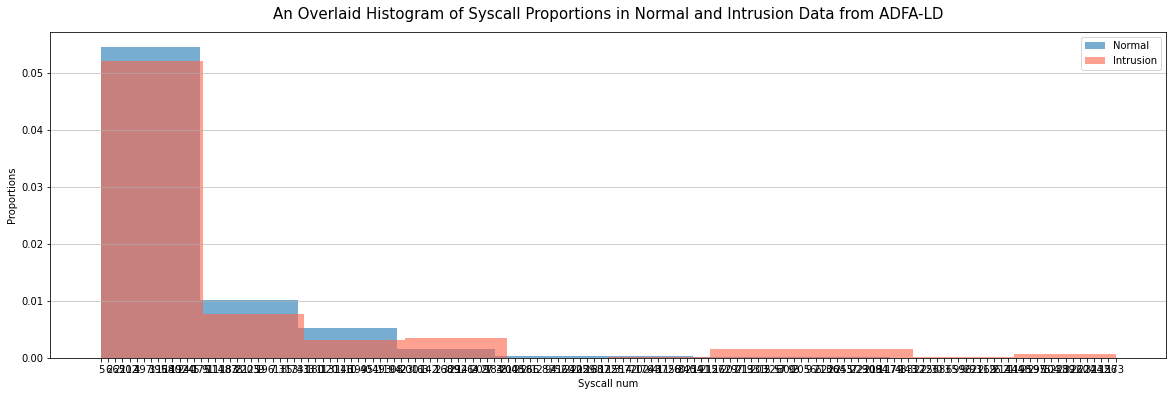

In [12]:
# After Cleaning
plt.figure(figsize=(20,6))
plt.hist(normal[0], label='Normal', alpha=0.6, density=True)
plt.hist(intrusion[0], label='Intrusion', color='tomato', alpha=0.6, density=True)
plt.legend()
plt.ylabel('Proportions')
plt.xlabel('Syscall num')
plt.grid(axis='y', alpha=0.75)
plt.title('An Overlaid Histogram of Syscall Proportions in Normal and Intrusion Data from ' + DATA,y=1.02, fontsize=15)

In [13]:
# Save cleaned train and test sets
normal.to_csv('normal.csv', index=False)
intrusion.to_csv('intrusion.csv', index=False)

**Labeling Sequences**

In [14]:
# Intrusion sequences is labeled 1.
intrusion['Label'] = 1
intrusion.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,Label
0,146,3,104,142,142,3,175,146,265,142,146,119,265,146,146,265,265,146,3,142,3,3,3,142,265,1
1,3,265,265,168,265,168,168,168,3,340,168,168,3,168,168,168,265,3,265,265,3,168,3,3,3,1
2,265,175,175,265,265,142,265,146,265,142,142,142,146,142,142,146,142,265,142,142,146,142,265,142,119,1
3,142,3,265,146,142,146,142,3,265,142,3,3,142,3,142,3,265,146,3,265,146,146,3,3,265,1
4,168,168,168,265,265,265,265,168,168,168,168,265,168,265,168,265,168,168,168,168,168,168,168,168,168,1


In [15]:
# Normal sequences is labeled 0.
print('Normal len:',len(normal),'\nIntrusion len:', len(intrusion))
normal['Label'] = 0
normal.head(5)

Normal len: 159435 
Intrusion len: 283550


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,Label
0,5,5,5,33,33,33,33,6,6,33,6,125,125,91,102,33,3,221,221,3,168,3,168,45,45,0
1,6,5,220,221,221,221,221,221,221,221,221,221,221,221,220,6,5,63,6,11,45,33,192,33,5,0
2,265,240,240,4,78,265,240,240,197,6,78,265,240,240,78,265,240,240,78,78,265,240,240,78,265,0
3,221,197,192,6,5,45,45,91,5,197,192,3,140,6,91,5,221,197,192,6,45,91,5,197,192,0
4,102,168,102,102,102,102,168,102,168,168,168,102,168,168,168,102,102,168,168,102,102,168,168,168,102,0


## **Partition Training and Testing dataset 70/30**

We do not need to bootstrap since there are more than enough data from both classes.

In [16]:
# combine normal(train) and intrusion(test) data and split them into training and testing sets
df = normal.append(intrusion, ignore_index=True).astype(int)
print('Df sz:', df.shape)

# Spliting into training and testing
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df['Label'], test_size = 0.30, shuffle=True)

# Reset index of training and testing sets
x_train.reset_index(drop=True, inplace=True); y_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True);  y_test.reset_index(drop=True, inplace=True)

print('Train sz:',len(x_train), len(y_train))
intrusion_train = y_train.loc[y_train == 1]
normal_train = y_train.loc[y_train == 0]
print('Train set: Intrusion vs. Normal cases', len(y_train.iloc[intrusion_train] ), len(y_train.iloc[normal_train] ))

print('Test sz:', len(x_test), len(y_test))
intrusion_test = y_test.loc[y_test == 1]
normal_test = y_test.loc[y_test == 0]
print('Test set: Intrusion vs. Normal cases', len(y_test.iloc[intrusion_test] ), len(y_test.iloc[normal_test] ))

Df sz: (442985, 26)
Train sz: 310089 310089
Train set: Intrusion vs. Normal cases 198591 111498
Test sz: 132896 132896
Test set: Intrusion vs. Normal cases 84959 47937


In [17]:
# SZ proportion is used when duplicated training data is not removed and the training sz is too big
#SZ = 1

x_train['Label'] = y_train

#x_train = x_train.append(x_train.sample(frac=1), ignore_index=True) # Bootstrap training data in case there is not enough data
x_train = x_train.sample(frac= SZ) # Shuffle data with a SZ proportion
x_train.reset_index(drop=True, inplace=True)
y_train = x_train['Label']
x_train.drop(columns='Label', inplace=True)
x_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,3,168,43,168,3,168,265,43,265,43,168,265,265,168,265,168,168,43,3,43,3,265,168,168,168
1,168,168,168,168,265,3,168,3,168,265,168,168,168,168,168,168,168,168,3,168,265,168,168,3,168
2,3,265,142,3,3,3,265,142,265,3,104,104,142,142,265,265,142,265,102,265,142,142,142,265,3
3,4,4,4,5,5,4,197,33,33,3,45,4,140,4,91,33,5,3,3,3,3,3,3,3,3
4,120,114,120,114,5,120,114,114,63,114,195,120,114,120,114,120,5,120,120,221,114,195,120,114,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310084,43,168,265,43,3,265,43,265,168,265,265,43,168,265,340,340,3,265,43,265,265,168,265,265,168
310085,168,168,43,265,3,43,168,265,265,3,265,3,340,43,168,168,168,168,168,168,265,168,168,3,168
310086,19,19,19,19,3,3,19,19,19,3,3,3,19,3,3,19,3,19,3,3,19,3,3,3,3
310087,6,265,78,4,240,168,54,102,6,265,78,78,265,102,102,102,13,102,102,102,102,6,195,5,197


In [18]:
x_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,3,168,43,168,3,168,265,43,265,43,168,265,265,168,265,168,168,43,3,43,3,265,168,168,168
1,168,168,168,168,265,3,168,3,168,265,168,168,168,168,168,168,168,168,3,168,265,168,168,3,168
2,3,265,142,3,3,3,265,142,265,3,104,104,142,142,265,265,142,265,102,265,142,142,142,265,3
3,4,4,4,5,5,4,197,33,33,3,45,4,140,4,91,33,5,3,3,3,3,3,3,3,3
4,120,114,120,114,5,120,114,114,63,114,195,120,114,120,114,120,5,120,120,221,114,195,120,114,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310084,43,168,265,43,3,265,43,265,168,265,265,43,168,265,340,340,3,265,43,265,265,168,265,265,168
310085,168,168,43,265,3,43,168,265,265,3,265,3,340,43,168,168,168,168,168,168,265,168,168,3,168
310086,19,19,19,19,3,3,19,19,19,3,3,3,19,3,3,19,3,19,3,3,19,3,3,3,3
310087,6,265,78,4,240,168,54,102,6,265,78,78,265,102,102,102,13,102,102,102,102,6,195,5,197


In [19]:
y_train

0         1
1         1
2         1
3         0
4         0
         ..
310084    1
310085    1
310086    1
310087    0
310088    1
Name: Label, Length: 310089, dtype: int64

In [20]:
x_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,168,168,265,3,265,168,3,265,265,168,168,265,168,3,168,265,265,168,265,265,3,265,168,3,265
1,221,168,4,168,102,4,168,42,168,4,168,102,168,102,6,6,168,4,168,42,221,221,221,221,221
2,3,3,265,265,265,168,168,168,168,168,168,265,168,265,168,265,3,265,168,3,168,168,168,168,168
3,219,219,219,219,219,219,219,240,240,240,240,240,240,240,219,219,219,240,240,240,240,219,219,240,240
4,180,78,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,240,240,240,240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132891,168,168,265,3,265,168,3,3,265,168,265,265,168,265,168,265,168,168,265,168,168,265,168,168,168
132892,265,265,3,265,168,168,168,265,168,168,265,168,265,265,265,3,168,265,265,168,3,265,265,265,3
132893,265,3,168,265,265,3,265,168,168,3,265,168,168,3,265,168,265,3,168,168,3,3,265,265,3
132894,265,265,3,3,3,265,3,3,168,265,168,265,3,265,3,265,3,3,168,265,3,168,168,3,168



# **Performance Measures**


1.   Function calc_false_positive: Calculates FPR
2.   Function print_performance: Formats printing performance metrics and ROC curve for each model
3.   Function color_confusion_matrix: prints out a heatmap of confusion matrix in blue color scale
4.   Graphing overlaid ROC curves, where each one represents a model AUC score





In [21]:
# This function calculate False Positive Rate given a confusion matrix
def calc_false_positive (cmatrix):
  specificity = cmatrix[0,0]/(cmatrix[0,0] + cmatrix[0,1])
  return 1-specificity

# This function prints performance metrics and ROC curve given the model name, true labels and predicted labels
def print_performance(model_name, true_labels, pred_labels):
  # rows are actual, columns are predicted
  cmatrix = confusion_matrix(true_labels, pred_labels)
  fpr = calc_false_positive(cmatrix)

  print('Confusion Matrix: \n',cmatrix)
  print('\nTesting Accuracy: %.2f'% metrics.accuracy_score(true_labels, pred_labels))
  print('Precision:%.2f'%  metrics.precision_score(true_labels, pred_labels))
  print('Recall: %.2f'% metrics.recall_score(true_labels, pred_labels))
  print('False Positive Rate: %.2f'% fpr)
  print('\nClassification report:', classification_report(true_labels, pred_labels), sep='\n')
  print('AUC: %.2f'% roc_auc_score(true_labels, pred_labels))

  false_positive_rate, recall, thresholds = roc_curve(true_labels, pred_labels)
  roc_auc = auc(false_positive_rate, recall)
  plt.figure()
  plt.title( model_name+' ROC Curve on ' + DATA)
  plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.2f' %roc_auc)
  plt.legend(loc='lower right')
  plt.plot([0,1], [0,1], 'r--')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.0])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  #plt.savefig(model_name+'-ROC.jpg')
  plt.show()

# Plot a heatmap of confusion matrix given the model name, a classifier model, testing data and the predicted label
def color_confusion_matrix( model_name, model, x_test, y_test, y_predicted):
  class_names = ['Normal', 'Intrusion']

  fig, ax = plt.subplots(figsize=(6, 6))
  plot_confusion_matrix(model, x_test, y_test, display_labels=class_names, 
                        values_format='d', ax = ax, cmap=plt.cm.Blues)
  plt.title('Confusion Matrix of ' + str(model_name))
  #plt.savefig(model_name+'-CM.jpg')
  plt.show()

  cmatrix = confusion_matrix(y_test, y_predicted)
  print(cmatrix)


# Graphing overlaid ROC curves, where each one represents a model AUC score
def graph_multi_ROC ():
  # Set color for each model
  colors = {'KM': 'lightcoral','LR': 'darkorange', 'SVM':'lime', 'NB': 'steelblue',
            'NN': 'purple','DT': 'magenta','RF': 'deeppink','KNN': 'darkturquoise',
            'BERT': 'darkred', 'GPT': 'blue'}
  # Set marker for each model          
  markers = {'KM':'1--','LR': 'v--', 'SVM': '^--', 'NN': '*--', 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'NB': 'x--', 'BERT':'<--', 'GPT': '>--'}
  
  plt.figure(figsize=(9,6))

  plt.plot(KM_test.get('fpr'), KM_test.get('tpr'), markers.get('KM'), color=colors.get('KM'),  label="KM - AUC=" + str(KM_test.get('auc').round(3)))
  plt.plot(LR_test.get('fpr'), LR_test.get('tpr'), markers.get('LR'), color=colors.get('LR'),  label="LR - AUC=" + str(LR_test.get('auc').round(3)))
  plt.plot(SVM_test.get('fpr'),SVM_test.get('tpr'),markers.get('SVM'),color=colors.get('SVM'), label="SVM - AUC="+ str(SVM_test.get('auc').round(3)))
  plt.plot(NN_test.get('fpr'), NN_test.get('tpr'), markers.get('NN'), color=colors.get('NN'),  label="NN - AUC=" + str(NN_test.get('auc').round(3)))
  plt.plot(DT_test.get('fpr'), DT_test.get('tpr'), markers.get('DT'), color=colors.get('DT'),  label="DT - AUC=" + str(DT_test.get('auc').round(3)))
  plt.plot(RF_test.get('fpr'), RF_test.get('tpr'), markers.get('RF'), color=colors.get('RF'),  label="RF - AUC=" + str(RF_test.get('auc').round(3)))
  plt.plot(KNN_test.get('fpr'),KNN_test.get('tpr'),markers.get('KNN'),color=colors.get('KNN'), label="KNN - AUC="+ str(KNN_test.get('auc').round(3)))
  plt.plot(NB_test.get('fpr'), NB_test.get('tpr'), markers.get('NB'), color=colors.get('NB'),  label="NB - AUC=" + str(NB_test.get('auc').round(3)))
  plt.plot(BERT_test.get('fpr'),BERT_test.get('tpr'), markers.get('BERT'), color=colors.get('BERT'),  label="BERT - AUC="+ str(BERT_test.get('auc').round(3)))
  plt.plot(GPT_test.get('fpr'),GPT_test.get('tpr'), markers.get('GPT'), color=colors.get('GPT'),  label="GPT-2 - AUC="+ str(GPT_test.get('auc').round(3)))

  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right') 
  plt.title( 'Testing ROCs on ' + DATA)
  #plt.savefig(DATA_I+'-'+train_or_test+'.jpg', dpi = 80)
  plt.show()

In [22]:
if len(x_train) < 10000:
  BATCH_SZ = 64
  EPOCHS = 3

BATCH_SZ, EPOCHS

(256, 2)

# **BERT**


In [23]:
!pip install pytorch_pretrained_bert pytorch-nlp

     |████████████████████████████████| 123 kB 13.6 MB/s 
     |████████████████████████████████| 90 kB 11.8 MB/s 
     |████████████████████████████████| 131 kB 64.8 MB/s 
     |████████████████████████████████| 8.2 MB 62.2 MB/s 
     |████████████████████████████████| 79 kB 9.1 MB/s 
     |████████████████████████████████| 138 kB 77.5 MB/s 
     |████████████████████████████████| 127 kB 66.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [24]:
from pytorch_pretrained_bert import BertModel
from torch import nn
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output

**Prepare for Train and test data for BERT**

In [25]:
train_texts = []
for i in range(x_train.shape[0]):
     train_texts.append(" ".join(np.array(x_train.iloc[i,:]).astype(str)))
train_texts = tuple(train_texts) 

test_texts = []
for i in range(x_test.shape[0]):
     test_texts.append(" ".join(np.array(x_test.iloc[i,:]).astype(str)))
test_texts = tuple(test_texts) 

train_labels = tuple(y_train.tolist())
test_labels = tuple(y_test.tolist())

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(310089, 310089, 132896, 132896)

In [26]:
# Tokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Example
tokenizer.tokenize(train_texts[8])

100%|██████████| 231508/231508 [00:00<00:00, 680735.64B/s]


['195',
 '195',
 '195',
 '5',
 '45',
 '140',
 '140',
 '6',
 '195',
 '140',
 '195',
 '195',
 '5',
 '3',
 '6',
 '195',
 '195',
 '140',
 '140',
 '6',
 '3',
 '6',
 '3',
 '6',
 '195']

In [ ]:
# Convert to tokens using tokenizer
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:SEQ_WINDOW] + ['[SEP]'], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:SEQ_WINDOW] + ['[SEP]'], test_texts))

print('Number of Training Sequences:',len(train_tokens), '\nNumber of Testing Sequences:', len(test_tokens) )       

In [ ]:
# Following is to convert List of words to list of numbers. (Words are replaced by their index in dictionar)
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen= SEQ_WINDOW, truncating="post", padding="post", dtype="int")
test_tokens_ids  = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)),  maxlen= SEQ_WINDOW, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

In [ ]:
# Prepare labels
# True if intrusion or False if normal
train_y = np.array(train_labels) == 1
test_y = np.array(test_labels) == 1
train_y.shape, test_y.shape, np.mean(train_y), np.mean(test_y)

In [ ]:
# To mask the paddings
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

In [ ]:
# Define BERT model
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        # First Layer
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)

        dropout_output = self.dropout(pooled_output)

        linear_output = self.linear(dropout_output)
        
        # output layer
        proba = self.sigmoid(linear_output)
        
        return proba
      
    def train_m(self,x,y,train_mask,epochs,batchsize):
      train_tokens_tensor = torch.tensor(x)
      train_y_tensor = torch.tensor(y.reshape(-1, 1)).float()
      train_masks_tensor = torch.tensor(train_mask)

      train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batchsize) 


      param_optimizer = list(self.sigmoid.named_parameters()) 
      optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
      optimizer = Adam(self.bert.parameters(), lr=2e-5)
      for epoch_num in range(epochs):
          self.train() # Training Flag
          train_loss = 0
          for step_num, batch_data in enumerate(train_dataloader):
              
              # Load batch on device memory
              token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

              # Get the output of the model for provided input
              logits = self(token_ids, masks)
              
              # Loss function
              loss_func = nn.BCELoss()

              # Calculate Loss
              batch_loss = loss_func(logits, labels)
              train_loss += batch_loss.item()
              
              # backpropagate the error
              self.zero_grad()
              batch_loss.backward()
              
              # Update the Weights of the Model
              clip_grad_norm_(parameters=self.parameters(), max_norm=1.0)
              optimizer.step()
              
              clear_output(wait=True)
              print('Epoch: ', epoch_num + 1)
              print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_labels) / batchsize, train_loss / (step_num + 1)))        

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()

**Fine Tune BERT**

In [ ]:
# Train BERT NLP
bert_clf.train_m(train_tokens_ids,train_y,train_masks,2,512)

**Evaluate on Testing Set**

In [ ]:
# Convert token ids to tensor 
test_tokens_tensor = torch.tensor(test_tokens_ids)

# Convert labels to tensors
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

# Convert to tensro for maks
test_masks_tensor = torch.tensor(test_masks)

# Load Token, token mask and label into Dataloader
test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)

# Define sampler
test_sampler = SequentialSampler(test_dataset)

# Defile test data loader
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=16)

In [ ]:
bert_clf.eval() # Define eval
bert_predicted = [] # To Store predicted result
all_logits = [] # Actual output that is between 0 to 1 is stored here
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        # Load the batch on gpu memory
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        # Calculate ouput of bert
        logits = bert_clf(token_ids, masks)

        # Get the numpy logits
        numpy_logits = logits.cpu().detach().numpy()  # Detach from the GPU memory
        
        # Using the threshold find binary 
        bert_predicted += list(numpy_logits[:, 0] > 0.5)  # Threshold conversion
        all_logits += list(numpy_logits[:, 0])

In [ ]:
print_performance('BERT',test_y, bert_predicted)

# Recording TPR and FPR for the TESTING-ROC curves
BERT_test = {}
BERT_test['fpr'], BERT_test['tpr'], thresh = roc_curve(test_y, bert_predicted)
BERT_test['auc'] = roc_auc_score(test_y, bert_predicted)

# **GPT-2**

In [ ]:
!pip install transformers

from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('microsoft/DialoGPT-small')

In [ ]:
# Padding sequences from the right to a max length of 20
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token
train_tokens = tokenizer(train_texts,return_tensors='pt',truncation=True,padding=True,max_length = SEQ_WINDOW)
test_tokens = tokenizer(test_texts,return_tensors='pt',truncation=True,padding=True,  max_length = SEQ_WINDOW)

In [ ]:
# Following is to convert List of words to list of numbers. (Words are replaced by their index in dictionar)

train_tokens_ids = train_tokens.input_ids
test_tokens_ids = test_tokens.input_ids

train_tokens_ids.shape, test_tokens_ids.shape

In [ ]:
train_masks = train_tokens.attention_mask
test_masks = test_tokens.attention_mask

**Create GPT-2 Classifer**

In [ ]:
class GTP2BinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(GTP2BinaryClassifier, self).__init__()
        self.gtp2 = GPT2ForSequenceClassification.from_pretrained('microsoft/DialoGPT-small')
      
    def train_m(self,x,y,train_mask,epochs,batchsize):
      train_tokens_tensor = torch.tensor(x)
      train_y_tensor = torch.tensor(y.reshape(-1, 1)).long()
      train_masks_tensor = torch.tensor(train_mask)

      train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batchsize) 


      # param_optimizer = list(self.gtp2.parameters()) 
      # optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
      optimizer = Adam(self.gtp2.parameters(), lr=5e-5)
      for epoch_num in range(epochs):
          self.gtp2.train() # Training Flag
          train_loss = 0
          for step_num, batch_data in enumerate(train_dataloader):
              
              # Load batch on device memory
              token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
              self.zero_grad()

              # Get the output of the model for provided input
              outputs = self.gtp2(token_ids,attention_mask=masks,labels=labels)
              loss, logits = outputs[:2]
              # logits = self(token_ids, masks)
              
              # Total Loss
              train_loss += loss.item()
              
              # Backward pass the loss
              loss.backward()
              torch.nn.utils.clip_grad_norm_(self.gtp2.parameters(), 1.0)
              
              optimizer.step()
              logits = logits.detach().cpu().numpy()

              clear_output(wait=True)
        
              print('Epoch: ', epoch_num + 1)
              print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_labels) / batchsize, train_loss / (step_num + 1)))
        

In [ ]:
gtp_clf = GTP2BinaryClassifier()
gtp_clf = gtp_clf.cuda()

In [ ]:
# Configure the Padding token id
gtp_clf.gtp2.config.pad_token_id = tokenizer.eos_token_id
gtp_clf.train_m(train_tokens_ids,train_y,train_masks,2,512)

**Evaluate on Testing Set**

In [ ]:
test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).long()

test_masks_tensor = torch.tensor(test_masks)


test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=128)


In [ ]:
# Evaluate Model
gtp_clf.eval() # Define eval
gpt_predicted = [] # Store Result
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        # ----------------------------------------------------------------
        outputs = gtp_clf.gtp2(token_ids,attention_mask=masks,labels=labels)
        loss, logits = outputs[:2]
        numpy_logits = logits.detach().cpu().numpy()
        # ----------------------------------------------------------------
        gpt_predicted +=list(numpy_logits.argmax(axis=-1).flatten().tolist())

In [ ]:
print_performance('GPT2',test_y, gpt_predicted)

# Recording TPR and FPR for the TESTING-ROC curves
GPT_test = {}
GPT_test['fpr'], GPT_test['tpr'], thresh = roc_curve(test_y, gpt_predicted)
GPT_test['auc'] = roc_auc_score(test_y, gpt_predicted) 

# **Write performance measures to file**

In [ ]:
# Save performance measure dict of each model to a file
def write_to_file (varname, model_name):
  clean_status = 'clean' if CLEAN else 'unclean'
  filename = DATA +'-'+ str(SEQ_WINDOW) +'-'+ clean_status + ".txt"
  file = open(filename, "a")
  str_dictionary = repr(varname)
  file.write("{}_test = ".format(model_name) + str_dictionary + "\n")
  file.close()


In [ ]:
write_to_file(BERT_test, 'BERT')
write_to_file(GPT_test, 'GPT')

In [ ]:
print('BERT_test = ', BERT_test)

print('\nGPT_test = ',GPT_test)

# **Graphing multi-ROC Curves**

In [ ]:
# Ploting the overlaid ROC curves on testing results:
graph_multi_ROC()

In [ ]:
print('BERT_test =', BERT_test)
print('GPT_test =', GPT_test)

# **Write performance measures to file**

In [ ]:
# Save performance measure dict of each model to a file
def write_to_file (varname, model_name):
  clean_status = 'clean' if CLEAN else 'unclean'
  filename = DATA +'-'+ str(SEQ_WINDOW) +'-'+ clean_status + ".txt"
  file = open(filename, "a")
  str_dictionary = repr(varname)
  file.write("{}_test = ".format(model_name) + str_dictionary + "\n")
  file.close()


In [ ]:
write_to_file(BERT_test, 'BERT')
write_to_file(GPT_test, 'GPT')


# **Note**

**Cleaned Data**
After changing the sequence length to 15 and only removing duplicate data in intrusion has significantly increased all model performances. BERT and GPT outperform the rest with over 0.97 AUC scores.